In [17]:
import numpy as np 
import pandas as pd
import os
import pickle
import gc

import ydata_profiling as ypf
# 可視化
import matplotlib.pyplot as plt

# モデリング
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
!pip install LightGBM
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline

In [4]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
x_train, y_train, id_train = df_train[['Pclass', 'Fare']], df_train[['Survived']], df_train[['PassengerId']]

In [5]:
# モデル学習、評価を関数化する

# ハイパーパラメータ
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metrics': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain',
}

def train_cv(input_x, input_y, input_id, params, n_split=5):
    metrics = []
    imp = pd.DataFrame()
    
    n_splits = 5
    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_train, y_train))
    
    for nfold in np.arange(n_splits):
        print('-'*20, nfold, '-'*20)
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
        x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
    
        model = lgb.LGBMClassifier(**params, force_row_wise=True)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr,y_tr),(x_va, y_va)],
                  callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=True),lgb.log_evaluation(1)]
                 )
        y_tr_pred = model.predict(x_tr)
        y_va_pred = model.predict(x_va)
        metric_tr = accuracy_score(y_tr, y_tr_pred)
        metric_va = accuracy_score(y_va, y_va_pred)
        metrics.append([nfold, metric_tr, metric_va])
        _imp = pd.DataFrame({'col': x_train.columns, "imp": model.feature_importances_})
        imp = pd.concat([imp, _imp], axis=0, ignore_index=True)
    
    print('-'*20, 'result', '-'*20)
    metrics = np.array(metrics)
    print(metrics)

    print('[cv ] tr: {:.2f}+-{:.2f}, va:{:.2f}+-{:.2f}'.format(
        metrics[:,1].mean(),metrics[:,1].std(),
        metrics[:,2].mean(),metrics[:,1].std(),
    ))
    imp = imp.groupby('col')['imp'].agg(['mean','std'])
    imp.columns = ['imp','imp_std']
    imp = imp.reset_index(drop=False)

    return imp, metrics

In [6]:
imp, metrics = train_cv(x_train, y_train, id_train, params, n_split=5)

-------------------- 0 --------------------
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[1]	training's auc: 0.762985	valid_1's auc: 0.729381
Training until validation scores don't improve for 10 rounds
[2]	training's auc: 0.763607	valid_1's auc: 0.730237
[3]	training's auc: 0.763607	valid_1's auc: 0.730237
[4]	training's auc: 0.777045	valid_1's auc: 0.732411
[5]	training's auc: 0.775702	valid_1's auc: 0.735046
[6]	training's auc: 0.777383	valid_1's auc: 0.72747
[7]	training's auc: 0.774955	valid_1's auc: 0.738274
[8]	training's auc: 0.776974	valid_1's auc: 0.739394
[9]	training's auc: 0.780612	valid_1's auc: 0.729644
[10]	training's auc: 0.788155	valid_1's auc: 0.736957
[11]	training's auc: 0.792636	valid_1's a

In [7]:
x_train = df_train[['Pclass', 'Fare', 'Age']]
imp, metrics = train_cv(x_train, y_train, id_train, params, n_split=5)
#  → tr: 0.76+-0.03, va:0.69+-0.03

-------------------- 0 --------------------
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[1]	training's auc: 0.782093	valid_1's auc: 0.657708
Training until validation scores don't improve for 10 rounds
[2]	training's auc: 0.795214	valid_1's auc: 0.669236
[3]	training's auc: 0.805598	valid_1's auc: 0.67859
[4]	training's auc: 0.810237	valid_1's auc: 0.674045
[5]	training's auc: 0.809636	valid_1's auc: 0.676943
[6]	training's auc: 0.822132	valid_1's auc: 0.696904
[7]	training's auc: 0.825949	valid_1's auc: 0.704743
[8]	training's auc: 0.82743	valid_1's auc: 0.701383
[9]	training's auc: 0.828135	valid_1's auc: 0.703755
[10]	training's auc: 0.834706	valid_1's auc: 0.700264
[11]	training's auc: 0.839153	valid_1's au

In [8]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [9]:
df_train.describe(exclude='number').T

,count,unique,top,freq
Name,891,891,"Braund, Mr. Owen Harris",1
Sex,891,2,male,577
Ticket,891,681,347082,7
Cabin,204,147,B96 B98,4
Embarked,889,3,S,644


In [11]:
# ypf.ProfileReport(df_train)

In [12]:
df_train['Age'].agg(['min','max'])

min     0.42
max    80.00
Name: Age, dtype: float64

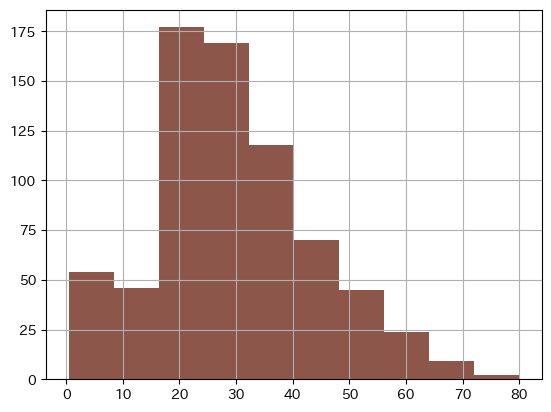

In [20]:
plt.hist(df_train['Age'], bins=10)
plt.show()

In [23]:
# 外れ値検出
quantile = df_train['Age'].quantile(q=0.75) - df_train['Age'].quantile(q=0.25)
print('四分位範囲', quantile)
print('下限値', df_train['Age'].quantile(q=0.25) - quantile * 1.5)
print('上限値', df_train['Age'].quantile(q=0.75) + quantile * 1.5)

# 推定だから間違っている可能性もあるので注意。無闇に適用しないこと。モデルの精度が上がらない場合やデータの異常が考えられるが他の方法で外れ値が検出できない場合などに使う。ｎ

四分位範囲 17.875
下限値 -6.6875
上限値 64.8125


In [ ]:
"""
特徴量選択の方法
    フィルター法：データセットのみ見て判断する方法。目的変数と特徴量１つずつの関係を評価して、有効性の有無を判定する。
    ラッパー法　：特徴量をモデルのみに適用してみて、モデルの精度の良し悪しから特徴量の有効性を判断する。
    組み込み法　：モデルの学習時に、同時に特徴量の選択を行う方法。→Lasso回帰が有名

    おすすめはラッパー法。モデルによって特徴量の捉え方が異なるので、作成した特徴量を適用したときのモデルの精度で判断する方法が良いと考える。
"""

In [32]:
!pip install optuna

In [43]:
import optuna

# ハイパーパラメータ
params_base = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metrics': 'auc',
    'learning_rate': 0.02,
    'n_estimators': 100000,
    'bagging_freq': 1,
    'seed': 123,
}

def objective(trial):
    params_tuning = {
        'num_leaves': trial.suggest_int('num_leaves', 8, 256),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 200),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-5, 1e-2, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-2, 1e2, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-2, 1e2, log=True),
    }
    params_tuning.update(params_base)

    list_metrics = []

    cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(x_train, y_train))
    
    for nfold in np.arange(5):
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
        x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
    
        model = lgb.LGBMClassifier(**params, force_row_wise=True)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr,y_tr),(x_va, y_va)],
                  callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)]
                 )
        y_va_pred = model.predict(x_va)
        metric_va = accuracy_score(y_va, np.where(y_va_pred >= 0.5, 1, 0))
        list_metrics.append(metric_va)
    return np.mean(list_metrics)

In [44]:
sampler = optuna.samplers.TPESampler(seed=123)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-12-29 22:23:13,156] A new study created in memory with name: no-name-1605abfc-1c09-4169-bc42-965e8ad4c8a3
[I 2024-12-29 22:23:13,367] Trial 0 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 4.792414358623587e-05, 'feature_fraction': 0.7756573845414456, 'bagging_fraction': 0.8597344848927815, 'lambda_l1': 0.49252223377910603, 'lambda_l2': 83.76388146302452}. Best is trial 0 with value: 0.6935911116690728.


[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's auc: 0.913235	valid_1's auc: 0.72892
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	training's auc: 0.837591	valid_1's auc: 0.745856
[LightGBM] [Info] Number of positive: 274, number o

[I 2024-12-29 22:23:13,914] Trial 1 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 99, 'min_sum_hessian_in_leaf': 0.00015009027543233888, 'feature_fraction': 0.6715890080754348, 'bagging_fraction': 0.8645248536920208, 'lambda_l1': 0.5679223741740078, 'lambda_l2': 0.01732652966363563}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[27]	training's auc: 0.864011	valid_1's auc: 0.775961
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's auc: 0.913235	valid_1's auc: 0.72892
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds


[I 2024-12-29 22:23:14,289] Trial 2 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 149, 'min_sum_hessian_in_leaf': 3.52756635172055e-05, 'feature_fraction': 0.5877258780737462, 'bagging_fraction': 0.7657756869209191, 'lambda_l1': 1.3406343673102121, 'lambda_l2': 3.448290408913144}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[11]	training's auc: 0.837591	valid_1's auc: 0.745856
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.811104	valid_1's auc: 0.768249
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's 

[I 2024-12-29 22:23:14,573] Trial 3 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 219, 'min_data_in_leaf': 146, 'min_sum_hessian_in_leaf': 0.0006808799287054756, 'feature_fraction': 0.8612216912851107, 'bagging_fraction': 0.6614794569265892, 'lambda_l1': 0.27999780223990095, 'lambda_l2': 0.08185645330667264}. Best is trial 0 with value: 0.6935911116690728.
[I 2024-12-29 22:23:14,765] Trial 4 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 128, 'min_sum_hessian_in_leaf': 1.889360449174926e-05, 'feature_fraction': 0.7168505863397641, 'bagging_fraction': 0.7154313816648219, 'lambda_l1': 0.9434967110751795, 'lambda_l2': 0.5050346330980693}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[27]	training's auc: 0.864011	valid_1's auc: 0.775961
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's auc: 0.913235	valid_1's auc: 0.72892
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	training's 

[I 2024-12-29 22:23:14,959] Trial 5 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 88, 'min_sum_hessian_in_leaf': 0.004788147156768277, 'feature_fraction': 0.9720800091019398, 'bagging_fraction': 0.7509183379421682, 'lambda_l1': 3.1319282717196035, 'lambda_l2': 0.029005047452739414}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[69]	training's auc: 0.913235	valid_1's auc: 0.72892
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	training's auc: 0.837591	valid_1's auc: 0.745856
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	training's a

[I 2024-12-29 22:23:15,151] Trial 6 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 86, 'min_sum_hessian_in_leaf': 0.003971252247766701, 'feature_fraction': 0.6252276826982534, 'bagging_fraction': 0.7415171321313522, 'lambda_l1': 87.54657140659083, 'lambda_l2': 1.1965765212602308}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[11]	training's auc: 0.837591	valid_1's auc: 0.745856
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.811104	valid_1's auc: 0.768249
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's 

[I 2024-12-29 22:23:15,339] Trial 7 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 28, 'min_sum_hessian_in_leaf': 0.0030131614432849746, 'feature_fraction': 0.8015300642054637, 'bagging_fraction': 0.7725340032332324, 'lambda_l1': 0.23499322154972468, 'lambda_l2': 0.1646202117975735}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[3]	training's auc: 0.811104	valid_1's auc: 0.768249
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's auc: 0.847634	valid_1's auc: 0.747326
[LightGBM] [Info] Number of positive: 273, number of negative: 440
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382889 -> initscore=-0.477303
[LightGBM] [Info] Start training from score -0.477303
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	training's 

[I 2024-12-29 22:23:15,598] Trial 8 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 138, 'min_sum_hessian_in_leaf': 0.00423029374725911, 'feature_fraction': 0.7552111687390055, 'bagging_fraction': 0.8346568914811361, 'lambda_l1': 2.2067148127117098, 'lambda_l2': 3.1594683442464047}. Best is trial 0 with value: 0.6935911116690728.


[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.811104	valid_1's auc: 0.768249
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's auc: 0.847634	valid_1's auc: 0.747326
[LightGBM] [Info] Number of positive: 273, number o

[I 2024-12-29 22:23:15,786] Trial 9 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 170, 'min_sum_hessian_in_leaf': 1.7765808030254076e-05, 'feature_fraction': 0.8818414207216692, 'bagging_fraction': 0.6218331872684371, 'lambda_l1': 0.05982625838323253, 'lambda_l2': 1.9490717640641546}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[11]	training's auc: 0.837591	valid_1's auc: 0.745856
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.811104	valid_1's auc: 0.768249
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's 

[I 2024-12-29 22:23:15,982] Trial 10 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 32, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.00010530695817517065, 'feature_fraction': 0.5040305717020104, 'bagging_fraction': 0.9940542446575643, 'lambda_l1': 0.010612397212799442, 'lambda_l2': 67.10287596337035}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[3]	training's auc: 0.811104	valid_1's auc: 0.768249
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's auc: 0.847634	valid_1's auc: 0.747326
[LightGBM] [Info] Number of positive: 273, number of negative: 440
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382889 -> initscore=-0.477303
[LightGBM] [Info] Start training from score -0.477303
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	training's 

[I 2024-12-29 22:23:16,197] Trial 11 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 245, 'min_data_in_leaf': 59, 'min_sum_hessian_in_leaf': 0.00019952242350034497, 'feature_fraction': 0.680510676303443, 'bagging_fraction': 0.9046129327183772, 'lambda_l1': 13.55100815052138, 'lambda_l2': 85.35741664238788}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[3]	training's auc: 0.811104	valid_1's auc: 0.768249
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's auc: 0.847634	valid_1's auc: 0.747326
[LightGBM] [Info] Number of positive: 273, number of negative: 440
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382889 -> initscore=-0.477303
[LightGBM] [Info] Start training from score -0.477303
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	training's 

[I 2024-12-29 22:23:16,423] Trial 12 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 57, 'min_sum_hessian_in_leaf': 7.659182988788056e-05, 'feature_fraction': 0.6570923224140477, 'bagging_fraction': 0.8899780780638389, 'lambda_l1': 0.14501718610211514, 'lambda_l2': 0.010232463153115963}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[3]	training's auc: 0.811104	valid_1's auc: 0.768249
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's auc: 0.847634	valid_1's auc: 0.747326
[LightGBM] [Info] Number of positive: 273, number of negative: 440
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382889 -> initscore=-0.477303
[LightGBM] [Info] Start training from score -0.477303
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	training's 

[I 2024-12-29 22:23:16,626] Trial 13 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 109, 'min_sum_hessian_in_leaf': 0.0006630877110584158, 'feature_fraction': 0.837025122599692, 'bagging_fraction': 0.5430552645659706, 'lambda_l1': 0.033837657134204495, 'lambda_l2': 16.048872499864505}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[3]	training's auc: 0.811104	valid_1's auc: 0.768249
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's auc: 0.847634	valid_1's auc: 0.747326
[LightGBM] [Info] Number of positive: 273, number of negative: 440
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382889 -> initscore=-0.477303
[LightGBM] [Info] Start training from score -0.477303
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	training's 

[I 2024-12-29 22:23:16,807] Trial 14 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 204, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 5.717717987936209e-05, 'feature_fraction': 0.5578428743173742, 'bagging_fraction': 0.9478369458173551, 'lambda_l1': 7.792559440024684, 'lambda_l2': 14.048839041680221}. Best is trial 0 with value: 0.6935911116690728.


[LightGBM] [Info] Number of positive: 273, number of negative: 440
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382889 -> initscore=-0.477303
[LightGBM] [Info] Start training from score -0.477303
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	training's auc: 0.864011	valid_1's auc: 0.775961
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's auc: 0.913235	valid_1's auc: 0.72892
[LightGBM] [Info] Number of positive: 274, number o

[I 2024-12-29 22:23:17,003] Trial 15 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 243, 'min_data_in_leaf': 67, 'min_sum_hessian_in_leaf': 0.00033040787452620027, 'feature_fraction': 0.7495517698115405, 'bagging_fraction': 0.8413048560197381, 'lambda_l1': 0.5860216156613824, 'lambda_l2': 0.2927113532128868}. Best is trial 0 with value: 0.6935911116690728.
[I 2024-12-29 22:23:17,192] Trial 16 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 112, 'min_sum_hessian_in_leaf': 0.00018784164693824454, 'feature_fraction': 0.9863422835511906, 'bagging_fraction': 0.851410424861598, 'lambda_l1': 6.236338820604067, 'lambda_l2': 12.68845523919227}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[27]	training's auc: 0.864011	valid_1's auc: 0.775961
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's auc: 0.913235	valid_1's auc: 0.72892
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	training's 

[I 2024-12-29 22:23:17,376] Trial 17 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 203, 'min_data_in_leaf': 84, 'min_sum_hessian_in_leaf': 1.158042029894523e-05, 'feature_fraction': 0.9197171562685666, 'bagging_fraction': 0.9323606407970545, 'lambda_l1': 38.23011167780388, 'lambda_l2': 0.04837506886369723}. Best is trial 0 with value: 0.6935911116690728.


[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's auc: 0.913235	valid_1's auc: 0.72892
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	training's auc: 0.837591	valid_1's auc: 0.745856
[LightGBM] [Info] Number of positive: 274, number o

[I 2024-12-29 22:23:17,569] Trial 18 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 192, 'min_sum_hessian_in_leaf': 0.0013206936578061411, 'feature_fraction': 0.7982392212545764, 'bagging_fraction': 0.8127751519094408, 'lambda_l1': 0.07579790826497941, 'lambda_l2': 0.01188874797017692}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[69]	training's auc: 0.913235	valid_1's auc: 0.72892
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	training's auc: 0.837591	valid_1's auc: 0.745856
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	training's a

[I 2024-12-29 22:23:17,766] Trial 19 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 26, 'min_data_in_leaf': 42, 'min_sum_hessian_in_leaf': 3.562764976211569e-05, 'feature_fraction': 0.70468696257256, 'bagging_fraction': 0.9938187588498407, 'lambda_l1': 0.48279881650982936, 'lambda_l2': 6.549199908903182}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[11]	training's auc: 0.837591	valid_1's auc: 0.745856
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.811104	valid_1's auc: 0.768249
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's 

[I 2024-12-29 22:23:17,968] Trial 20 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 225, 'min_data_in_leaf': 101, 'min_sum_hessian_in_leaf': 0.00012900355443870758, 'feature_fraction': 0.6402149158291418, 'bagging_fraction': 0.8866299986002277, 'lambda_l1': 0.018991646784323135, 'lambda_l2': 26.431339754051077}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[3]	training's auc: 0.811104	valid_1's auc: 0.768249
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's auc: 0.847634	valid_1's auc: 0.747326
[LightGBM] [Info] Number of positive: 273, number of negative: 440
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382889 -> initscore=-0.477303
[LightGBM] [Info] Start training from score -0.477303
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	training's 

[I 2024-12-29 22:23:18,157] Trial 21 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 158, 'min_sum_hessian_in_leaf': 3.593271863664184e-05, 'feature_fraction': 0.6051287052482378, 'bagging_fraction': 0.7832506732776294, 'lambda_l1': 1.6514000298458829, 'lambda_l2': 4.156916351584709}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[16]	training's auc: 0.847634	valid_1's auc: 0.747326
[LightGBM] [Info] Number of positive: 273, number of negative: 440
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382889 -> initscore=-0.477303
[LightGBM] [Info] Start training from score -0.477303
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	training's auc: 0.864011	valid_1's auc: 0.775961
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's

[I 2024-12-29 22:23:18,368] Trial 22 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 185, 'min_sum_hessian_in_leaf': 4.362576016235821e-05, 'feature_fraction': 0.5744796213142894, 'bagging_fraction': 0.6704793574378827, 'lambda_l1': 0.9856756213569424, 'lambda_l2': 0.6302264257303645}. Best is trial 0 with value: 0.6935911116690728.
[I 2024-12-29 22:23:18,555] Trial 23 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 123, 'min_sum_hessian_in_leaf': 2.310098438235442e-05, 'feature_fraction': 0.5102400853215387, 'bagging_fraction': 0.8072607134383624, 'lambda_l1': 0.46111813747377395, 'lambda_l2': 45.191827331891616}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[27]	training's auc: 0.864011	valid_1's auc: 0.775961
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's auc: 0.913235	valid_1's auc: 0.72892
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	training's 

[I 2024-12-29 22:23:18,747] Trial 24 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 74, 'min_sum_hessian_in_leaf': 0.0003762233937533676, 'feature_fraction': 0.5658698695392914, 'bagging_fraction': 0.7026983677031235, 'lambda_l1': 3.5952552526826915, 'lambda_l2': 0.1556293360755586}. Best is trial 0 with value: 0.6935911116690728.


[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's auc: 0.913235	valid_1's auc: 0.72892
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	training's auc: 0.837591	valid_1's auc: 0.745856
[LightGBM] [Info] Number of positive: 274, number o

[I 2024-12-29 22:23:18,936] Trial 25 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 99, 'min_sum_hessian_in_leaf': 7.768365379969924e-05, 'feature_fraction': 0.7485826141312114, 'bagging_fraction': 0.8658752226638118, 'lambda_l1': 0.1300014137742713, 'lambda_l2': 6.892890525418996}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[69]	training's auc: 0.913235	valid_1's auc: 0.72892
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	training's auc: 0.837591	valid_1's auc: 0.745856
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	training's a

[I 2024-12-29 22:23:19,125] Trial 26 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 168, 'min_sum_hessian_in_leaf': 1.0080282578342995e-05, 'feature_fraction': 0.6748099499133925, 'bagging_fraction': 0.931597560015761, 'lambda_l1': 1.3198505214286191, 'lambda_l2': 1.5309771162083439}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[11]	training's auc: 0.837591	valid_1's auc: 0.745856
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.811104	valid_1's auc: 0.768249
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's 

[I 2024-12-29 22:23:19,318] Trial 27 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 46, 'min_sum_hessian_in_leaf': 0.00016695591142069498, 'feature_fraction': 0.5997291251136706, 'bagging_fraction': 0.8031630721757818, 'lambda_l1': 0.25427390969124913, 'lambda_l2': 31.54508096515745}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[3]	training's auc: 0.811104	valid_1's auc: 0.768249
[LightGBM] [Info] Number of positive: 274, number of negative: 439
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384292 -> initscore=-0.471371
[LightGBM] [Info] Start training from score -0.471371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's auc: 0.847634	valid_1's auc: 0.747326
[LightGBM] [Info] Number of positive: 273, number of negative: 440
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382889 -> initscore=-0.477303
[LightGBM] [Info] Start training from score -0.477303
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	training's 

[I 2024-12-29 22:23:19,505] Trial 28 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 122, 'min_sum_hessian_in_leaf': 6.8305100303546e-05, 'feature_fraction': 0.7919753394873922, 'bagging_fraction': 0.5898177727170965, 'lambda_l1': 13.611257110413906, 'lambda_l2': 0.023063221163797425}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[16]	training's auc: 0.847634	valid_1's auc: 0.747326
[LightGBM] [Info] Number of positive: 273, number of negative: 440
[LightGBM] [Info] Total Bins 181
[LightGBM] [Info] Number of data points in the train set: 713, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382889 -> initscore=-0.477303
[LightGBM] [Info] Start training from score -0.477303
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	training's auc: 0.864011	valid_1's auc: 0.775961
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	training's

[I 2024-12-29 22:23:19,683] Trial 29 finished with value: 0.6935911116690728 and parameters: {'num_leaves': 222, 'min_data_in_leaf': 143, 'min_sum_hessian_in_leaf': 0.0007084761848130609, 'feature_fraction': 0.7208079207745085, 'bagging_fraction': 0.6770145123660526, 'lambda_l1': 0.6880424935145814, 'lambda_l2': 0.07964791320835117}. Best is trial 0 with value: 0.6935911116690728.


Early stopping, best iteration is:
[27]	training's auc: 0.864011	valid_1's auc: 0.775961


In [46]:
trial = study.best_trial
print('acc(best)={:.4f}'.format(trial.value))
display(trial.params)

acc(best)=0.6936


{'num_leaves': 181,
 'min_data_in_leaf': 61,
 'min_sum_hessian_in_leaf': 4.792414358623587e-05,
 'feature_fraction': 0.7756573845414456,
 'bagging_fraction': 0.8597344848927815,
 'lambda_l1': 0.49252223377910603,
 'lambda_l2': 83.76388146302452}

In [49]:
params_best = trial.params
params_best.update(params_base)
params_best

{'num_leaves': 181,
 'min_data_in_leaf': 61,
 'min_sum_hessian_in_leaf': 4.792414358623587e-05,
 'feature_fraction': 0.7756573845414456,
 'bagging_fraction': 0.8597344848927815,
 'lambda_l1': 0.49252223377910603,
 'lambda_l2': 83.76388146302452,
 'boosting_type': 'gbdt',
 'objective': 'binary',
 'metrics': 'auc',
 'learning_rate': 0.02,
 'n_estimators': 100000,
 'bagging_freq': 1,
 'seed': 123}

In [50]:
lr_train = pd.read_csv('./train.csv')
x_train_lr = lr_train[['Pclass', 'Age', 'Embarked']]
y_train_lr = lr_train[['Survived']]

In [53]:
x_train_lr.shape, y_train_lr.shape

((891, 3), (891, 1))

In [58]:
x_train_lr['Age'] = x_train_lr['Age'].fillna(x_train_lr['Age'].mean())
x_train_lr['Embarked'] = x_train_lr['Embarked'].fillna(x_train_lr['Embarked'].mode()[0])

In [61]:
ohe = OneHotEncoder()
ohe.fit(x_train_lr[['Embarked']])

OneHotEncoder()

In [63]:
df_embarked = pd.DataFrame(ohe.transform(x_train_lr[['Embarked']]).toarray(),
                            columns=['Embarked_{}'.format(col) for col in ohe.categories_[0]])
df_embarked

,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
886,0.0,0.0,1.0
887,0.0,0.0,1.0
888,0.0,0.0,1.0
889,1.0,0.0,0.0


In [64]:
x_train_lr = pd.concat([x_train_lr, df_embarked], axis=1)
x_train_lr = x_train_lr.drop(columns=['Embarked'])
x_train_lr

,Pclass,Age,Embarked_C,Embarked_Q,Embarked_S
0,3,22.000000,0.0,0.0,1.0
1,1,38.000000,1.0,0.0,0.0
2,3,26.000000,0.0,0.0,1.0
3,1,35.000000,0.0,0.0,1.0
4,3,35.000000,0.0,0.0,1.0
...,...,...,...,...,...
886,2,27.000000,0.0,0.0,1.0
887,1,19.000000,0.0,0.0,1.0
888,3,29.699118,0.0,0.0,1.0
889,1,26.000000,1.0,0.0,0.0


In [67]:
x_train_lr['Pclass'] = (x_train_lr['Pclass'] - x_train_lr['Pclass'].min()) / (x_train_lr['Pclass'].max() - x_train_lr['Pclass'].min())

In [70]:
x_train_lr['Age'] = (x_train_lr['Age'] - x_train_lr['Age'].min()) / (x_train_lr['Age'].max() - x_train_lr['Age'].min())

In [72]:
x_tr, x_va, y_tr, y_va = train_test_split(x_train_lr, y_train_lr, test_size=0.2, stratify=y_train_lr, random_state=123)
print(x_tr.shape, x_va.shape, y_tr.shape, y_va.shape)

(712, 5) (179, 5) (712, 1) (179, 1)


In [73]:
from sklearn.linear_model import LogisticRegression
model_logis = LogisticRegression()

model_logis.fit(x_tr, y_tr)

y_va_pred = model_logis.predict(x_va)
print(accuracy_score(y_va, y_va_pred))
print(y_va_pred[:5])

0.7262569832402235
[0 1 0 1 0]


In [75]:
from sklearn.svm import SVC

model_svm = SVC(C=1.0, random_state=123, probability=True)
model_svm.fit(x_tr, y_tr)

y_va_pred = model_svm.predict(x_va)
print(accuracy_score(y_va, y_va_pred))
print(y_va_pred[:5])

y_va_pred_prob = model_svm.predict_proba(x_va)
print(y_va_pred_prob[:5])

0.7150837988826816
[0 1 0 1 0]
[[0.73990307 0.26009693]
 [0.28229766 0.71770234]
 [0.73990072 0.26009928]
 [0.2682028  0.7317972 ]
 [0.58944465 0.41055535]]
